In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr8kimagescaptions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F771078%2F1328792%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240714%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240714T203252Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D721e6664671f1ec2e41926c3f7dccb46487d210e45079674bac19170f4fbf03cb3422d15da94bada0df9526f243ed73feaec841e7e5641c94e5bb8605199949496cfed0901c1a5ec6cbea081fd7edbcc383c0dc70a705bed941d16852f1a135cf748395e6e4050610506460d70ae870029f9d07b7deffa48ca5edf4f898187b50379098987eed0a8af341d60ff60be130672d79ff3145bf9925fc19556e0cc270fb285dde64ad2b5184b50fc94f9013b27ebdeda6ad632b5a049e81061b2b7616da3a50d21002c7b15e11f50e1063c0a3d3beab69d4a5d853855a8e43f3d2b54b2ded4fa0c880633124010f20a358a7dbe91277ca81550d237055dbdc76d1cef'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


## Imports

In [ ]:
import numpy as np
import pandas as pd
import os
from fastai.vision.all import *
from fastai.text.all import *
from pathlib import Path
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchtext
from torchtext.data import get_tokenizer
from collections import Counter
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.image as Image
import PIL
from PIL import Image
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data PreProcessing

We have both images and captions in a csv file. Both are easily accessible, one in a csv file and corresponding image using the image id.

In [ ]:
captions_path = "/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt"
images_path = "/kaggle/input/flickr8kimagescaptions/flickr8k/images"

In [ ]:
df = pd.read_csv(captions_path)

print(f"No of captions: {len(df)}")
df.head()

No of captions: 40455


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                                    caption  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .  
3                      A little girl climbing the stairs to her playhouse .  
4                 A little girl in a pink dress going into a wooden cabin .

In [ ]:
class my_dictionary(dict):

    # __init__ function
    def __init__(self):
        self = dict()

    # Function to add key:value
    def add(self, key, value):
        if key not in self.keys():
            self[key] = [value]
        else:
            self[key].append(value)

descriptors = my_dictionary()

In [ ]:
for i in range(len(df)):
    img_id = df.iloc[i, 0]
    sentence = ("<start> " + df.iloc[i, 1] + " <end>").split()

    descriptors.add(img_id, sentence)

In [ ]:
print(descriptors['1001773457_577c3a7d70.jpg'])

[['<start>', 'A', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', '<end>'], ['<start>', 'A', 'black', 'dog', 'and', 'a', 'tri-colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road', '.', '<end>'], ['<start>', 'A', 'black', 'dog', 'and', 'a', 'white', 'dog', 'with', 'brown', 'spots', 'are', 'staring', 'at', 'each', 'other', 'in', 'the', 'street', '.', '<end>'], ['<start>', 'Two', 'dogs', 'of', 'different', 'breeds', 'looking', 'at', 'each', 'other', 'on', 'the', 'road', '.', '<end>'], ['<start>', 'Two', 'dogs', 'on', 'pavement', 'moving', 'toward', 'each', 'other', '.', '<end>']]


**Check any Image**

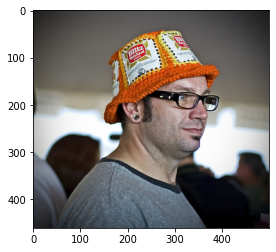

A man in an orange hat starring at something .


In [ ]:
# get image path
image_indx = 20
image_path = images_path +"/"+ df.iloc[image_indx, 0]

# read the image
img = Image.open(image_path)
plt.imshow(img)
plt.show()

# print the captions related to this image
for i in range(image_indx, image_indx+1):
    print(df.iloc[i, 1])

In [ ]:
# TOKENIZER
tokenizer = get_tokenizer("basic_english")   # works for HINDI also

# TOKEN COUNTER
token_counter = Counter()

In [ ]:
class textVocab:
    # method to initialize the variables
    def __init__(self):
        # MAIN DICT
        # create dict (int to word) (like token counter)
        self.itos = {0:"<PAD>", 1:"<start>", 2:"<end>", 3:"<UNK>"}

        # create dict (word to int)
        self.stoi = {b:a for a, b in self.itos.items()}

        # initialize word freq threshold
        self.min_freq = 1

        # MAIN COMPONENTS
        # tokenizer
        self.tokenizer = get_tokenizer("basic_english")   # works for HINDI also

        # token counter
        self.token_counter = Counter()

    # method to get size of vocabulary
    def __len__(self):
        return len(self.itos)

    # method to tokenize sentence
    def tokenize(self, text):
        return self.tokenizer(text)

    # method to numericalize sentence
    def numericalize(self, text):

        # tokenize the sentence
        tokens_list = self.tokenize(text)

        ans = []
        # convert words into ints (using stoi)
        for token in tokens_list:
            if token in self.stoi.keys():
                ans.append(self.stoi[token])
            else:
                ans.append(self.stoi["<UNK>"])
        return ans
#         return [ self.stoi[token] if token in self.stoi.keys() else self.stoi["<UNK>"] for token in tokens_list]

    # method to add new sentences to dict
    def build_vocab(self, sentence_list):
        word_count = 4

        # for each sentence
        for sentence in sentence_list:

            # tokenize
            tokens = self.tokenizer(sentence)

            # numericalize
            token_counter.update(tokens)

            # add words to vocab whose freq is >= min freq
            for token in tokens:
                if token_counter[token] >= self.min_freq and token not in self.stoi.keys():
                    self.stoi[token] = word_count
                    self.itos[word_count] = token
                    word_count += 1

In [ ]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
class MyInceptionFeatureExtractor(nn.Module):
    def __init__(self, inception, transform_input=False):
        super(MyInceptionFeatureExtractor, self).__init__()
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = inception.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception.Conv2d_2b_3x3

        # extra layers has been added since the comment
        self.maxpool1 = inception.maxpool1
        self.Conv2d_3b_1x1 = inception.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception.Conv2d_4a_3x3
        self.maxpool2 = inception.maxpool2

        self.Mixed_5b = inception.Mixed_5b
        self.Mixed_5c = inception.Mixed_5c
        self.Mixed_5d = inception.Mixed_5d
        self.Mixed_6a = inception.Mixed_6a
        self.Mixed_6b = inception.Mixed_6b
        self.Mixed_6c = inception.Mixed_6c
        self.Mixed_6d = inception.Mixed_6d
        self.Mixed_6e = inception.Mixed_6e

        self.AuxLogits = inception.AuxLogits

        self.Mixed_7a = inception.Mixed_7a
        self.Mixed_7b = inception.Mixed_7b
        self.Mixed_7c = inception.Mixed_7c

        # stop where you want, copy paste from the model def

    def forward(self, x):
#         if self.transform_input:
#             x = x.clone()
#             x[0] = x[0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
#             x[1] = x[1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
#             x[2] = x[2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5

        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = self.maxpool1(x)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = self.maxpool2(x)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 17 x 17 x 768
        x = self.Mixed_5c(x)
        # 17 x 17 x 768
        x = self.Mixed_5d(x)
        # 17 x 17 x 768
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)

        # were not working so i have to remove it
#         x = self.AuxLogits(x)

        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)

        return x

In [ ]:
# define the transforms
inception_Transform = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## DATASETS AND DATALOADERS

### Custom Dataset

In [ ]:
class customDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None, min_freq=5):
        self.image_dir = image_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # get image ids and captions
        self.img_ids = self.df["image"]
        self.sentences = self.df["caption"]

        # initialize vocabulary
        self.vocab = textVocab()

        # create vocabulary (using list of sentences)
        self.vocab.build_vocab(self.sentences.tolist())

    def __len__(self):
        return len(self.df)

    # method to return pair of input and output data
    def __getitem__(self, idx):

        # get the caption and image path
        sentence = self.sentences[idx]
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.image_dir, img_id)

        # open the image
        img = Image.open(img_path).convert("RGB")

        # apply transformation on image(resize)
        if self.transform is not None:
            img = self.transform(img)

        # numericalize the caption
        vec = []

        vec += [self.vocab.stoi["<start>"]]   # tagging
        vec += self.vocab.numericalize(sentence)  # numericalization
        vec += [self.vocab.stoi["<end>"]]     # tagging

        # return text vector and image tensor
#         return img_id, vec
        return img, torch.tensor(vec), img_id

In [ ]:
transforms = inception_Transform

In [ ]:
transforms

Compose(
    Resize(size=299, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(299, 299))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
# Create custom dataset object
dataset = customDataset(
    image_dir = images_path,
    captions_file = captions_path,
    transform = transforms
)

In [ ]:
with open('vocab.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(dataset.vocab, file)

In [ ]:
validation_split = .1
shuffle_dataset = False
random_seed= 42

In [ ]:
dataset_size = len(dataset)
indices = list(range(dataset_size))

# find the split point
split = int(np.floor(validation_split * dataset_size))

# get the indices
train_indices, val_indices = indices[split:], indices[:split]

# shuffle the dataset
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

**Check our dataset**

In [ ]:
# create utility function to print images
def show_image(img, title=None):

    # unnormalize
    img[0] *= 0.229
    img[1] *= 0.224
    img[2] *= 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)

    plt.pause(0.001)    # wait for plots

2355819665_39021ff642.jpg


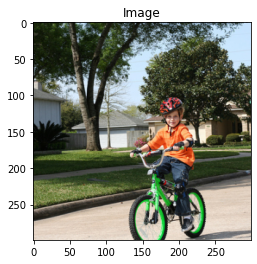

caption:  ['<start>', 'boy', 'wearing', 'safety', 'gear', 'rides', 'green', 'bike', 'through', 'suburban', 'streets', '.', '<end>']


In [ ]:
# get an item from dataset
img, vec, img_id = dataset[8083]
print(img_id)
show_image(img, "Image")

# need to convert returned vector into sentence
caption = [dataset.vocab.itos[token] for token in vec.tolist()]
print("caption: ", caption)

### DataLoaders

**Padding function**

In [ ]:
class Collate_fn:
    def __init__(self, pad_value, batch_first=False):
        self.pad_value = pad_value       # initialize padding value
        self.batch_first = batch_first    # col or row wise representation

    # this method is called for each batch in dataloader
    def __call__(self, batch):
        # get all inputs images
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)    # single tensor

        # get all captions
        captions = [item[1] for item in batch]

        # do padding on all text vectors   # single tensor
        captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)

        # get all image ids
        img_ids = [item[2] for item in batch]

        return imgs, captions, img_ids

In [ ]:
# define batch size
batch_size = 64

# initialize value to represent padding
pad_value = dataset.vocab.stoi["<PAD>"]

In [ ]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [ ]:
dls = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size, shuffle=False,
                                           collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=valid_sampler)

In [ ]:
# # create dataloader object
# dls = DataLoader(
#         dataset = dataset,
#         batch_size = batch_size,
#         shuffle = True,       # without it gives images in row
#         collate_fn = Collate_fn(pad_value=pad_value, batch_first = True)
# )

**Check Dataloader**

two boys in a tent smile for the camera .


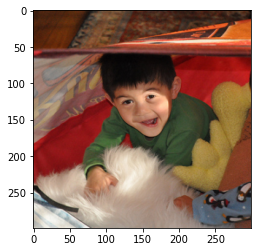

In [ ]:
# dataloader iterator
dlsItr = iter(dls)

# get a batch
batch = next(dlsItr)

# get input and output values
imgs, captions, img_ids = batch

# show all items in it
for i in range(batch_size):
    img, caption = imgs[i], captions[i]

    # convert text vector into sentence
    sentence = [dataset.vocab.itos[token] for token in caption.tolist()]

    # get index of end token
    end_indx = sentence.index('<end>')

    # get from start to end and join
    sentence = sentence[1:end_indx]
    sentence = ' '.join(sentence)

    # also print image
    print(sentence)
    show_image(img)
    plt.show()

    break

## Model Implementation

### Encoder Model

This model is used to encode the images by applying a Pretrained CNN model to extract features.

Here, we can use pre-trained VGG16, InceptionV3 and Resnet50 CNN model. But we will go with inceptionV3 (all have similar results).

https://colab.research.google.com/drive/1RP-XrrNEirNPfA3WluCrbsOJqlVKxbF1#scrollTo=izbiAvYrnqpq

Check which layers we are getting

**For resnet50**: -

Final layers (normally): -

    (2): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=2048, out_features=1000, bias=True)
  
  
Final layers (after removing last 2 layers): -

    (2): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    )
    )
    
**For inception**

Normally : -

    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=2048, out_features=1000, bias=True)
  
After removing 3 layers:-

    (branch_pool): BasicConv2d(
    (conv): Conv2d(2048, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    )
    )

Note - removing last 3 layers of model does not works with inception v3. should find some other way to extract features matrix.

In [ ]:
inception = models.inception_v3(pretrained=True)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.my_inception = MyInceptionFeatureExtractor(inception)
        # initialize the pretrained model (Tested by Balwant)
#         inception = models.inception_v3(pretrained=True)
#         inception.eval()

#         # set the parameteres
#         for para in inception.parameters():
#             para.requires_grad_(False)

#         modules = list(inception.children())[:-3]
#         self.inception = nn.Sequential(*modules)

    def forward(self, images):
#         print(images.shape) = [bs, 3, 299, 299]

        # get the feature maps
        features = self.my_inception(images)
#         print(features.shape) = [bs, 2048, 8, 8]

        features = features.permute(0, 2, 3, 1)
#         print(features.shape) = [bs, 8, 8, 2048]

        features = features.view(features.size(0), -1, features.size(-1))
#         print(features.shape) = [2, 64, 2048]

        return features

## Attention Model

- encoder_dim: feature size of encoded images
- decoder_dim: size of decoder's RNN
- attention_dim: size of the attention network

**Attention model** it is a simple model with 3 linear layers.

We transform the image feature tensor into a attention score(alpha-averaged hence deterministic or soft attention). and usign this alpha we get attention weights tensor.

In [ ]:
class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        # initialize the shapes
        self.attention_dim = attention_dim

        # create linear layer's to transform following
        # (input shape, output shape)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # decoder's output
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # encoded image
        self.full_att = nn.Linear(attention_dim, 1)  # attention's output

    # input - features of image and hidden state value
    def forward(self, features, hidden_states):
        # pass the tensor's through linear layers
        att1 = self.encoder_att(features)
        att2 = self.decoder_att(hidden_states)

#         print(att1.shape, att2.shape)   # torch.Size([32, 64, att_dim]) torch.Size([32, att_dim])

        # combine both attentions
        combined_states = torch.tanh(att1 + att2.unsqueeze(1))

#         print(combined_states.shape)      # torch.Size([32, 64, att_dim])

        # pass combined state through last linear layer
        attention_scores = self.full_att(combined_states)

#         print(attention_scores.shape)     # torch.Size([bs, 64, 1])
        attention_scores = attention_scores.squeeze(2)
#         print(attention_scores.shape)   # torch.Size([32, 64])


        # calculate alpha
        alpha = F.softmax(attention_scores, dim=1)

        # get attention weights
        weighted_encoding = features * alpha.unsqueeze(2)   # torch.Size([bs, 64, 1])
        weighted_encoding = weighted_encoding.sum(dim=1)    # sum all weights at dim 1

        # return alpha and attention weights (both are tensors)
        return alpha, weighted_encoding


## Decoder Model

- attention_dim: size of attention network
- embed_dim: embedding size
- decoder_dim: size of decoder's RNN
- vocab_size: size of vocabulary
- encoder_dim: feature size of encoded images
- dropout: dropout

In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()

        # initialize the model parameters
        self.vocab_sz = vocab_sz
        self.att_dim = att_dim
        self.dec_dim = dec_dim

        # initialize embedding model and attention model
        self.embedding = nn.Embedding(vocab_sz, embed_sz)
        self.attention = Attention(enc_dim, dec_dim, att_dim)

        # create the hidden and cell state
        self.init_h = nn.Linear(enc_dim, dec_dim)
        self.init_c = nn.Linear(enc_dim, dec_dim)

        # create lstm cell
        self.lstm_cell = nn.LSTMCell(embed_sz + enc_dim, dec_dim, bias=True)

        # create other nn layers
        self.f_beta = nn.Linear(dec_dim, enc_dim)
        self.fcn = nn.Linear(dec_dim, vocab_sz)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):

        # vectorize the captions(tokenized):
        embeds = self.embedding(captions)

        # initialize hidden and cell state
        h, c = self.init_hidden_state(features)

        # get the captions length in current batch
        cap_len = len(captions[0]) - 1

        # get batch size and features size
        batch_sz = captions.size(0)
        num_features = features.size(1)

        # create tensor of zeros for predictions and alpha
        preds = torch.zeros(batch_sz, cap_len, self.vocab_sz).to(device)
        alphas = torch.zeros(batch_sz, cap_len, num_features).to(device)

        for i in range(cap_len):
            # get alpha and attention weights
            alpha, att_weights = self.attention(features, h)

            # create lstm input
            lstm_input = torch.cat((embeds[:,i], att_weights), dim=1)

            # pass through lstm cell
            h, c = self.lstm_cell(lstm_input, (h, c))

            # pass through linear layer
            output = self.fcn(self.drop(h))

            # store the output and alpha
            preds[:, i] = output
            alphas[:, i] = alpha

        return preds, alphas

    # create method to generate captions
    def generate_caption(self, features, max_len=20, vocab=None):
        batch_sz = features.size(0)

        # hidden and cell state
        h, c = self.init_hidden_state(features)

        alphas = []
        captions = [vocab.stoi['<start>']]

        # starting input
        word = torch.tensor(vocab.stoi['<start>']).view(1, -1).to(device)
        embeds = self.embedding(word)

        # get next 20 words
        for i in range(max_len):
            alpha, weighted_encoding = self.attention(features, h)

            # store alpha score
            alphas.append(alpha.cpu().detach().numpy())

            # update hidden and cell state
            lstm_input = torch.cat((embeds[:, 0], weighted_encoding), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            # pass through layers
            output = self.fcn(self.drop(h))
            output = output.view(batch_sz, -1)

            # select the best word
            pred_word_idx = output.argmax(dim=1)

            # save the word
            captions.append(pred_word_idx.item())

            # stop when end of sentence
            if vocab.itos[pred_word_idx.item()] == '<end>':
                break

            # next input
            embeds = self.embedding(pred_word_idx.unsqueeze(0))

        # return sentence
        return [vocab.itos[idx] for idx in captions], alphas  # if idx != 0 and idx != 1 and idx != 2

    # method to get hidden and cell state value
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)

        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)

        # return hidden and cell state
        return h, c

## Encoder - decoder model

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()

        # crete the encoder and decoder models
        self.encoder = Encoder()
        self.decoder = Decoder(
            embed_sz = embed_sz,
            vocab_sz = vocab_sz,
            att_dim = att_dim,
            enc_dim = enc_dim,
            dec_dim = dec_dim
        )

    def forward(self, images, captions):
        # extract image features
        features = self.encoder(images)

        # generate captions
        outputs = self.decoder(features, captions)

        # return predicted caption, attention alphas
        return outputs

## Set the Hyperameters

In [ ]:
embed_sz = 300
vocab_sz = len(dataset.vocab)
att_dim = 256
enc_dim = 2048
dec_dim = 512
learning_rate = 3e-4

## Model

In [ ]:
# initialize model
model = EncoderDecoder(
    embed_sz = 300,
    vocab_sz = len(dataset.vocab),
    att_dim = 128,
    enc_dim = 2048,
    dec_dim = 256
).to(device)

In [ ]:
# create criterion and optimizer for weights
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [ ]:
# function to save model
def save_model(model, num_epochs):
    model_state = {
        'num_epochs' : num_epochs,
        'embed_sz' : embed_sz,
        'vocab_sz' : len(dataset.vocab),
        'enc_dim' : enc_dim,
        'dec_dim' : dec_dim,
        'state_dict' : model.state_dict()
    }

    torch.save(model_state, 'Unclean5Sentences.pth')

Create the training loops.

In [ ]:
epochs = 12
print_each = 100

Epoch: 1 loss: 4.84810
<start> a a a a a a a . <end>


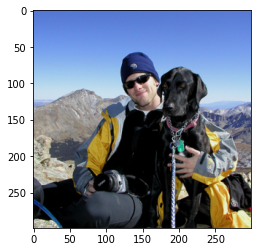

Epoch: 1 loss: 4.42902
<start> a dog is in a dog . <end>


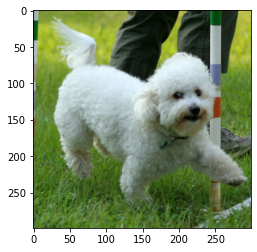

Epoch: 1 loss: 4.23841
<start> a man in a red in a red in a red . <end>


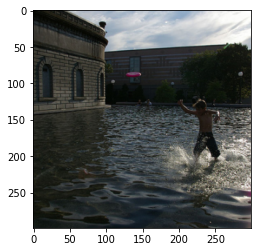

Epoch: 1 loss: 3.98191
<start> a dog is running in the water . <end>


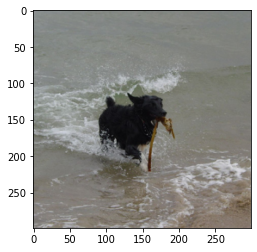

Epoch: 1 loss: 3.86990
<start> two dogs are running in the snow . <end>


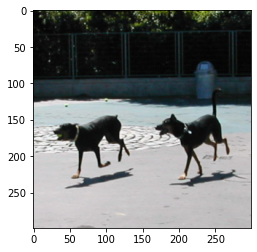

Epoch: 2 loss: 3.70706
<start> a boy in a red shirt is standing on a red shirt . <end>


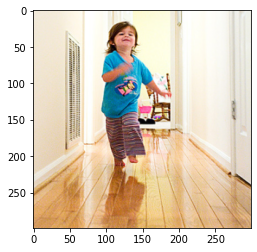

Epoch: 2 loss: 3.49646
<start> a dog is running through the grass . <end>


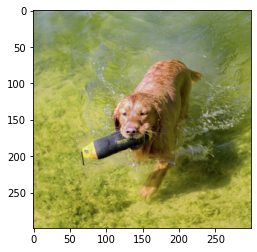

Epoch: 2 loss: 3.42463
<start> a group of people are standing on a rock . <end>


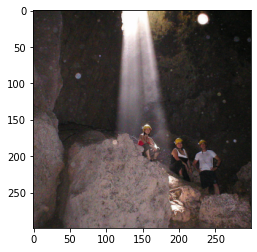

Epoch: 2 loss: 3.47380
<start> a dog is running through the grass . <end>


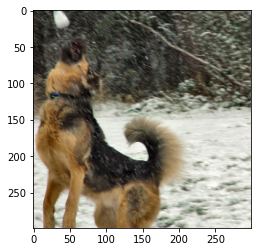

Epoch: 2 loss: 3.35639
<start> two boys are playing in the grass . <end>


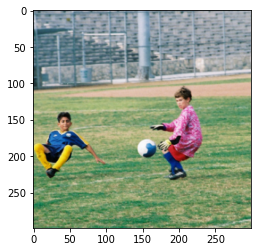

Epoch: 3 loss: 3.41901
<start> a man in a red shirt is running on a field . <end>


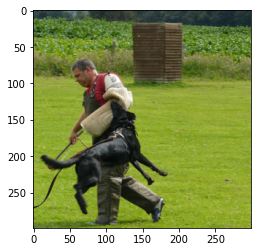

Epoch: 3 loss: 3.26549
<start> a girl in a red shirt is jumping on a mountain . <end>


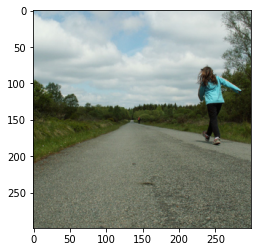

Epoch: 3 loss: 3.26184
<start> two dogs are running in the grass . <end>


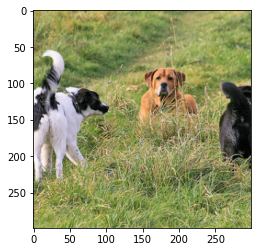

Epoch: 3 loss: 3.16985
<start> a group of people are sitting on a bench . <end>


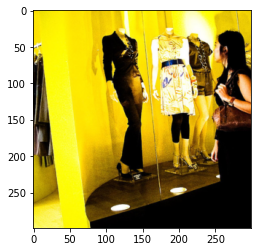

Epoch: 3 loss: 3.19616
<start> a woman in a blue shirt is standing in the water . <end>


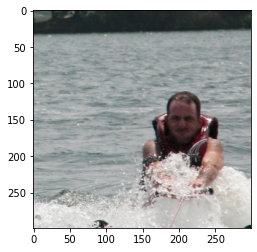

Epoch: 4 loss: 3.02094
<start> a man in a blue shirt is standing in a blue shirt and a red shirt is standing in the


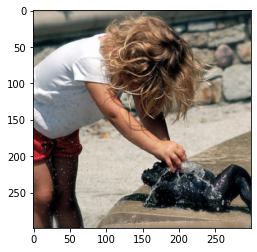

Epoch: 4 loss: 2.94250
<start> a boy in a blue shirt is standing on a rock . <end>


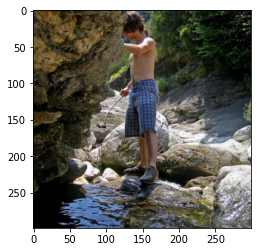

Epoch: 4 loss: 3.02784
<start> a girl in a pink shirt is standing on a bench . <end>


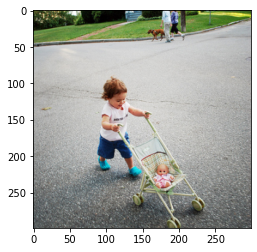

Epoch: 4 loss: 3.07742
<start> two children are playing in the grass . <end>


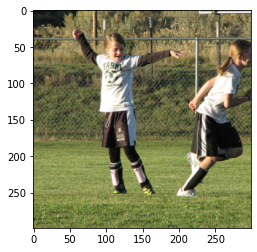

Epoch: 4 loss: 3.03980
<start> a dog is jumping over a hurdle . <end>


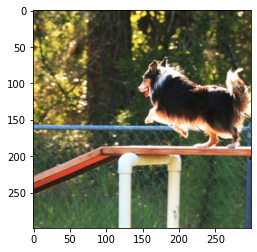

Epoch: 5 loss: 2.65525
<start> a group of people are standing in front of a building . <end>


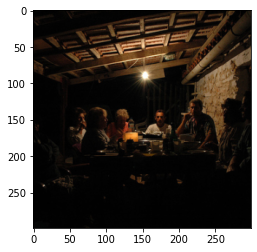

Epoch: 5 loss: 2.65838
<start> a black dog is running through the grass . <end>


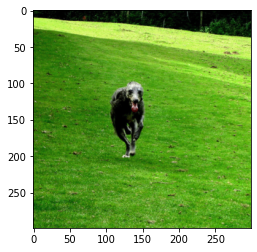

Epoch: 5 loss: 2.92227
<start> two children are playing in a field . <end>


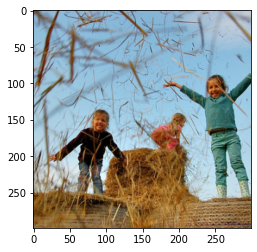

Epoch: 5 loss: 2.91335
<start> a black dog is running through a field . <end>


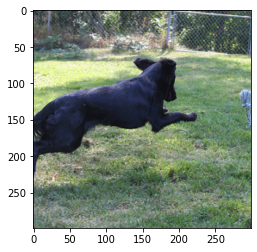

Epoch: 5 loss: 2.86846
<start> a dog is running through a grassy field . <end>


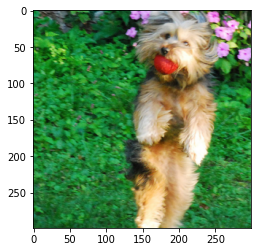

Epoch: 6 loss: 2.97564
<start> a person in a black shirt is standing on a sidewalk . <end>


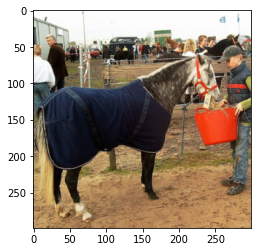

Epoch: 6 loss: 2.86161
<start> a boy is jumping in the air on a wave . <end>


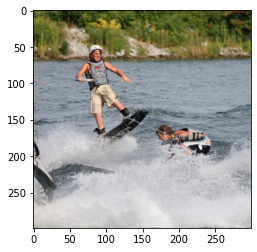

Epoch: 6 loss: 2.74489
<start> a man is standing in front of a table . <end>


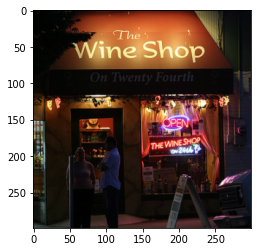

Epoch: 6 loss: 2.73453
<start> a dog jumps into the water . <end>


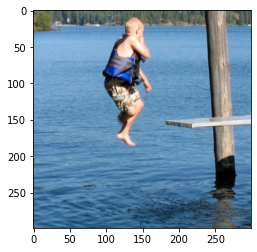

Epoch: 6 loss: 2.54875
<start> a woman in a blue shirt is standing on a dock in front of a lake . <end>


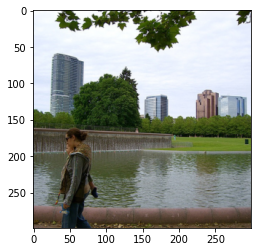

Epoch: 7 loss: 2.77094
<start> a man is climbing a rock . <end>


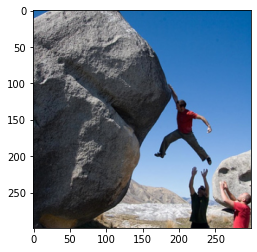

Epoch: 7 loss: 2.80603
<start> three dogs are playing in the grass . <end>


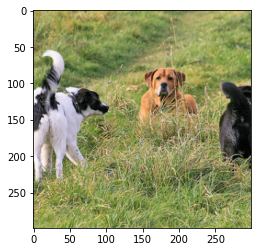

Epoch: 7 loss: 2.62918
<start> two people are standing on a beach . <end>


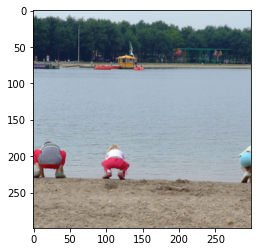

Epoch: 7 loss: 2.70739
<start> a young girl is sitting on a bed . <end>


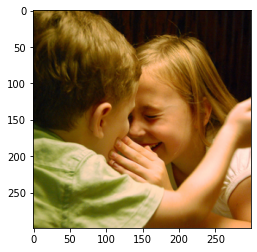

Epoch: 7 loss: 2.60180
<start> three men in a white shirt and a red shirt and a red shirt and a white shirt and a


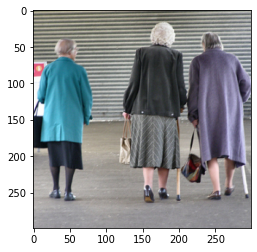

Epoch: 8 loss: 2.38693
<start> two people are standing in a field . <end>


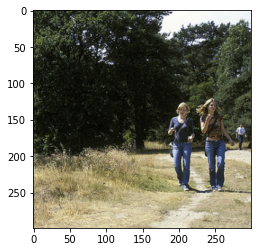

Epoch: 8 loss: 2.38950
<start> two people are sitting on a bench . <end>


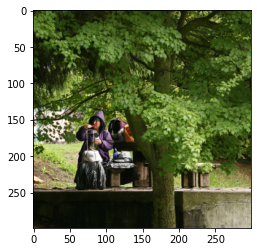

Epoch: 8 loss: 2.41891
<start> a brown dog is standing on a rock in the woods . <end>


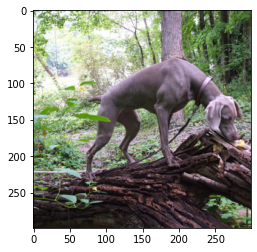

Epoch: 8 loss: 2.48481
<start> a young boy in a white shirt and white shirt is jumping in the air . <end>


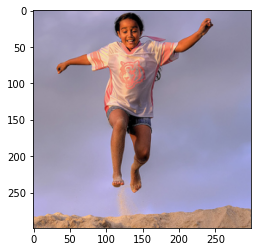

Epoch: 8 loss: 2.56444
<start> a group of children are playing on a playground . <end>


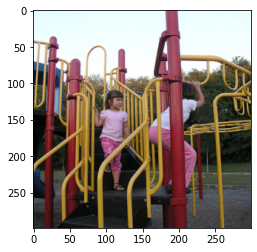

Epoch: 9 loss: 2.49346
<start> a group of people are walking through the snow . <end>


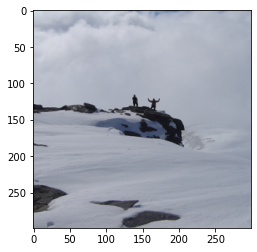

Epoch: 9 loss: 2.46097
<start> a person is climbing on a cliff overlooking a cliff . <end>


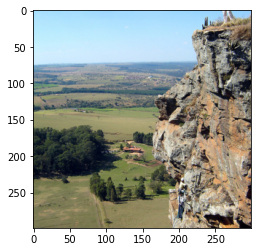

Epoch: 9 loss: 2.31467
<start> a girl in a blue shirt is running through a puddle . <end>


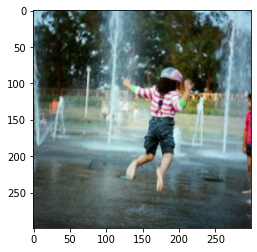

Epoch: 9 loss: 2.41938
<start> a girl is climbing a rock . <end>


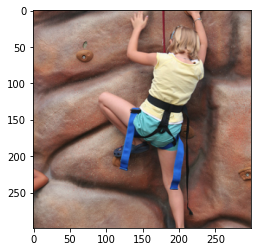

Epoch: 9 loss: 2.40194
<start> a man and a woman walking on the beach . <end>


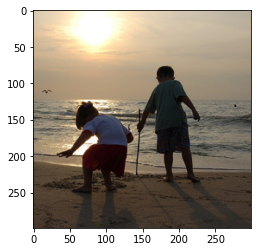

Epoch: 10 loss: 2.29136
<start> a woman wearing a blue hat and a hat is riding a bike . <end>


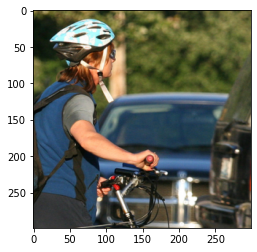

Epoch: 10 loss: 2.50451
<start> a black dog jumps into a pool . <end>


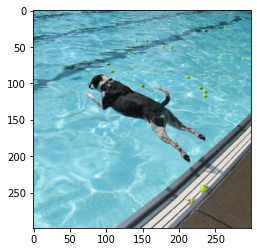

Epoch: 10 loss: 2.49396
<start> a young girl in a blue shirt and a blue shirt and a blue shirt and walking down a rock


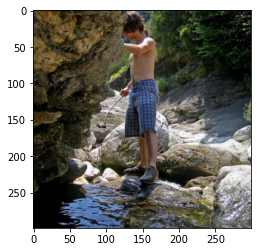

Epoch: 10 loss: 2.39996
<start> three young people are walking on a sidewalk . <end>


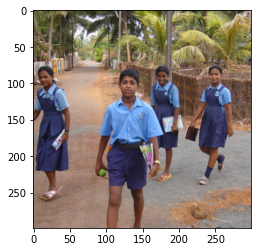

Epoch: 10 loss: 2.30794
<start> a little girl and a baby in a white dress . <end>


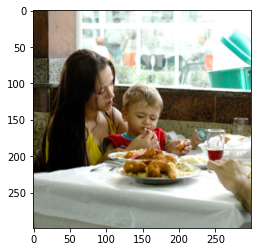

Epoch: 11 loss: 2.26530
<start> a man is climbing a rock wall . <end>


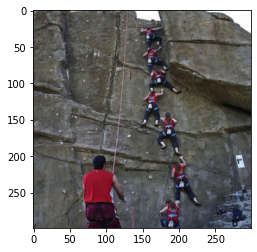

Epoch: 11 loss: 2.29605
<start> a man is climbing a rock wall . <end>


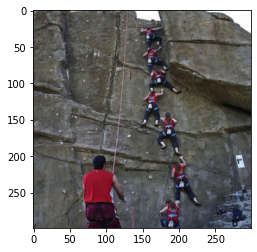

Epoch: 11 loss: 2.22332
<start> a man and a woman are sitting on a dirt hill . <end>


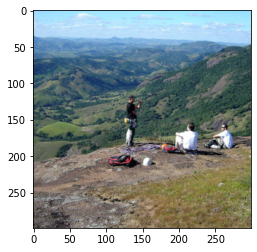

Epoch: 11 loss: 2.41167
<start> a dog runs on a rocky path . <end>


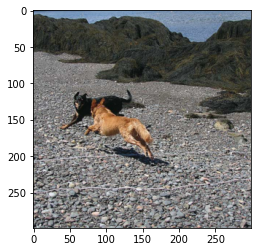

Epoch: 11 loss: 2.32099
<start> a man and woman are sitting on a bench with a man in a white shirt and black shirt sitting


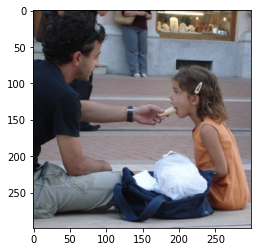

Epoch: 12 loss: 2.13635
<start> a dog is sitting in a car . <end>


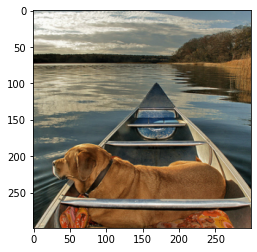

Epoch: 12 loss: 2.46306
<start> a man is standing on a beach . <end>


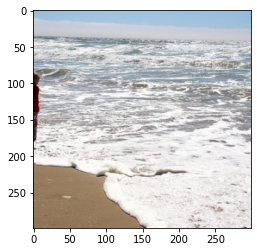

Epoch: 12 loss: 2.23273
<start> two dogs are playing with a red ball in its mouth . <end>


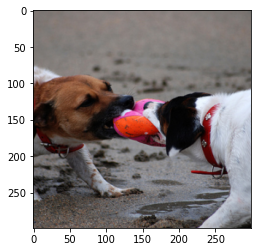

Epoch: 12 loss: 2.35551
<start> a young boy in a blue shirt is running on a wooden bench . <end>


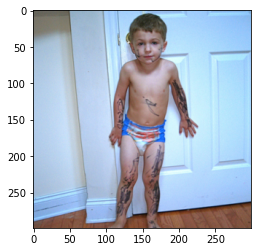

Epoch: 12 loss: 2.08096
<start> a man in a yellow jacket is driving a fire on a rocky road . <end>


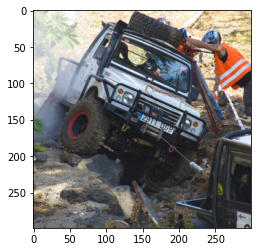

In [ ]:
model.train()
for epoch in range(1, epochs+1):
    for idx, (img, captions, img_ids) in enumerate(iter(dls)):

        # store the device (same-same)
        img, captions = img.to(device), captions.to(device)

        # make gradients zero
        optimizer.zero_grad()

        # pass through encoder-decoder model
        pred_caps, attentions = model(img, captions)

        # calculate batch loss
        targets = captions[:, 1:]

        loss = criterion(pred_caps.view(-1, vocab_sz), targets.reshape(-1))

        # backward pass
        loss.backward()    # update the NN weights

        # update the weights in optimizer
        optimizer.step()

        # if it is batch to print
        if (idx + 1) % print_each == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch, loss.item()))

            # generate the captions for a whole batch
            model.eval()
            with torch.no_grad():
                # dls or validation_loader
                itr = iter(validation_loader)
                img, _, _ = next(itr)

                # extract features
                features = model.encoder(img[0:1].to(device))

                # get predictions
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

                # make it printable
                caption = ' '.join(pred_caps)
                print(caption)
                show_image(img[0])

            # tell now will train
            model.train()

    # save latest model
    save_model(model, epoch)

## Model Testing

**MAKE PREDICTIONS**

We have downloaded the model from previous saved notebooks and will use those to predict and evaluating.

https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

In [ ]:
PATH = '/kaggle/working/Unclean5Sentences.pth'

In [ ]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])

# No use
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']  # ALREADY DEFFINED ABOE
# loss = checkpoint['loss']

<All keys matched successfully>

Original: <start> a woman sits on a bench at the park with her dog in front of her . <end>
torch.Size([1, 3, 299, 299])
Predicted: <start> a little girl is standing on a bench with a small dog . <end>


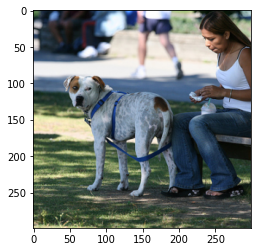

In [ ]:
# generate the captions for a whole batch
model.eval()
with torch.no_grad():
    # dls or validation_loader
    itr = iter(validation_loader)
    img, captions, img_ids = next(itr)

    caption = captions[0:1][0].tolist()
    s = [dataset.vocab.itos[idx] for idx in caption if idx != 0] # if idx != 0 and idx != 1 and idx != 2
    print("Original:", ' '.join(s))

    # extract features
    print(img[0:1].shape)
    features = model.encoder(img[0:1].to(device))

    # get predictions
    pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

    # make it printable
    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    show_image(img[0])

In [ ]:
def evaluateModel(mode, dls):
    model.eval()

    # to store references and predictions
    y, yhat = list(), list()

    # iterate all batches
    for idxx, (img, captions, img_ids) in enumerate(iter(dls)):
        print(idxx)
        with torch.no_grad():

            # iterate each record in batch
            for i in range(batch_size):

                # if empty record
                if len(captions[i:i+1]) == 0:
                    break

                # caption = captions[0:1][0].tolist()
                caption = captions[i:i+1][0].tolist()
                s = [dataset.vocab.itos[idx] for idx in caption if idx != 0] #  and idx != 1 and idx != 2

                y.append(descriptors[img_ids[i]])

                # extract features
                features = model.encoder(img[i:i+1].to(device))

                # get predictions
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

                yhat.append(pred_caps)
                # make it printable
                caption = ' '.join(pred_caps)
#                 print("Predicted ", caption)
#                 show_image(img[i])

#     y = [y]
#     print(y[0])
#     print(yhat[0])

    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(y, yhat, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(y, yhat, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(y, yhat, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(y, yhat, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
evaluateModel(model, validation_loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
BLEU-1: 0.652057
BLEU-2: 0.451815
BLEU-3: 0.337439
BLEU-4: 0.203079
